# Tutorial 1: Getting Started with MT using 🤗 Transformers

Welcome to the first tutorial of our course on "Practical Machine Translation for Low Resource Languages". Today, we will be learning about how to loading pre-trained Machine Translation models to perform translation in a variety of languages. We will start by introducing the higher-level [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines) that can be used to perform translation (or many other NLP tasks) by writing a couple of lines of code. We then remove the curtain from the Pipeline API and go into more internal details that are relevant for working with MT models in practice. 

Pre-requisites for the Tutorial:
- Intermediate Level Python Programming
- Working with Jupyter-Notebooks

References:
1. [🤗 Tutorial on Translation](https://huggingface.co/course/chapter7/4?fw=pt)
2. [API reference of Text Generation](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.GenerationConfig)
3. [Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [ ]:
# Installing the necessary packages that we will be using for the tutorial

!pip install torch # Installing Pytorch that we will use as a backend for transformers
!pip install transformers # Installing the transformers library
!pip install sacrebleu # For evaluation of MT models
!pip install evaluate # For evaluation of MT models

In [ ]:
# Some necessary imports
from tqdm.notebook import tqdm

## Task 1: The Big Picture
To begin this tutorial, we demonstrate the high-level operation of translation pipeline. You can use the `pipeline` API in the transformers library to load and use pre-trained NLP models within a couple of lines of code! Below we demonstrate how to do the same.
P.S. Make sure your Kaggle Notebook is connected to the Internet (Setting -> Internet On) to run the following code-blocks. 

In [ ]:
from transformers import pipeline

In [ ]:
# Let's take an example sentence in English
input_sequence = "This is a tutorial on the use of Machine Translation."

# Let's create a black-box that can handle the translation for us and pass it the units we initialized
translation_module = pipeline(task = "translation", model = 'Helsinki-NLP/opus-mt-en-fr', tokenizer = 'Helsinki-NLP/opus-mt-en-fr')

# Let's generate a translation through this black-box
translation = translation_module(input_sequence)
print('Translation: ' + translation[0]['translation_text'])

Under the hood, there are three concrete steps involved in the pipeline - 

**1.Preparing a sequence so that it can be fed to a translation model**: Consider that you want to translate an input sequence in English to its equivalent in French. Before the English sentence can be fed to our translation black box, we need to transform the sequence into a format that our black box can handle; This process broadly involves mapping the sequence to a numeric representation that a model can understand meaninfully and we use **_a tokenizer_** to do this for us.        
**2.Feeding this pre-processed sequence to our translation black box**: Once we have prepared a numeric representation of our English sentence, we feed it to our black box which _encodes the meaning_ and _constructs the corresponding representation_ in French. 

**3.Post-Processing the model's numeric representation to convert it reconstruct a French sentence**: Since we fed our black box with a numeric representation of our English sentence, it would be natural to assume that the black box's output would also be a numeric representation. To map this output to a readable french sentence, we again use the tokenizer. 


In [ ]:
# Under the Hood - The following steps unfold 
# Step 1: We use our tokenizer to prepare this sentence for our black box; We use a MarianTokenizer to do this 

from transformers import MarianTokenizer, MarianMTModel 

# You can learn more about this class of models at https://huggingface.co/docs/transformers/model_doc/marian

In [ ]:
 
# Observe the numeric representation of the sentence and try a few samples yourself! (Do you see any interesting patterns ?) 

# Initializing our Black Box and it's tokenizer
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-fr')
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

prepared_sequence = tokenizer.encode(input_sequence, return_tensors = 'pt')
print(f'{prepared_sequence} is the tokenized input.')

# Step 2: Feeding the input to the model 
numeric_output = model.generate(input_ids = prepared_sequence)


# Step 3: Decoding the model's numeric output  
translation = tokenizer.decode(numeric_output[0], skip_special_tokens=True)
print(f'Translation: {translation}')


## Task 2: Exploring Tokenizers in Translation
 
As you saw, the first step in engineering a translation pipeline is __making a model-understandable representation of the input sequence__. Since this the first step in any translation p A tokenizer is responsible for modelling this representation in two steps: 

1. Breaking a sequence into discrete units
2. Mapping them to numerical representations

Let's look at both these steps in detail

### Converting a Sequence to Discrete Units 

This step involves breaking down a sequence into characters, tokens or sub-tokens to encourage the model to associate these units with some meaning (which can then be combined to represent a large, even unseen, set of inputs) that we feed to the model.




In [ ]:

# Consider our example sentence:
input_sequence = "This is a tutorial on the use of Machine Translation."

# A simple way to convert this sentence into it's discrete units is simply assuming each character to be a discrete unit: 
char_tokenized_input = [*input_sequence]

# This is actually a naive-version of a character-tokenizer. 
print(f'Character Tokenizer Output: {char_tokenized_input}')

In [ ]:
#  Another way to convert this sentence into it's discrete tokens can be space-splitting the sentence: 
space_tokenized_input = input_sequence.split(' ')

# This method would be called a word-piece tokenization - since the resulting tokens are language word-tokens. 
print(f'Word-Piece Tokenizer Output: {space_tokenized_input}')

#### Similar to such variants, there are more sophisticated tokenizers that are adopted for preparing translation inputs for current translation models. 
_(Can you guess why character and word-piece tokenizers may not be appropriate ? **Hint for 1st: Do you associate alphabets with meaning ?** )_

For example: The tokenizer we loaded in our previous task exercise, MarianTokenizer, is based on the **sentencepiece tokenization scheme**.

Let's load a sentencepeice tokenizer and see the difference in how it treats our input: 

In [ ]:
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
input_sequence = "This is a tutorial on the use of Machine Translation."
prepared_input = tokenizer.encode(input_sequence)
tokens = [tokenizer.decode(input) for input in prepared_input]
print(f'Sentence Piece Tokenized Output: {tokens}')    
## Looks pretty similar to our word-piece tokenization output for now. Let's try with a longer sentence .. 

input_sequence += "Don't you just love Transformers ? Fascinating data structures."
prepared_input = tokenizer.encode(input_sequence)
tokens = [tokenizer.decode(input) for input in prepared_input]
print(f'Sentence Piece Tokenized Output: {tokens}')    
## Some interesting observations here (Look for "fascinating","Don't" or "Transformers")
    

The break-up of tokens that you observed with sentence-piece tokenizer is a product of it's property of being a **sub-word tokenizer**. As the name suggests, this tokenization scheme breaks a sequence into discrete tokens which aren't necessarily stand-alone tokens but rather the most commonly appearing sub-tokens across the sequence (_Can you guess the advantage of this?_) 

### Mapping Discrete Units to Numerical Representations

Once a sequence has been converted into its discrete units, we need to assign each discrete unit a numeric representation; This fundamentally involves storing these discrete units in an indexed fashion - where one unit can be numerically can be represented by the index it occupies. The dictionary, or vocabulary as it is called, which lists the index of every discrete unit is the backbone of a tokenizer. Let's revisit our MarianTokenizer to see this play out.  

In [ ]:
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-fr')

In [ ]:
print(tokenizer.vocab_size) # These are the number of discrete units that can be indexed, or represented by this tokenizer.  

In [ ]:
input_sequence = "This is a tutorial on the use of Machine Translation."
token_ids = tokenizer.encode(input_sequence)
print(token_ids)

Try and do this with multiple sentences ? Do you see a pattern with the outputs ? **Are some token ids recurring ?** 

## Task 3: Peeking Inside the Translation Model

In this part of the tutorial we look at the the next important component of a translation pipeline i.e. a translation model. For the course we will be considering Transformer-based translation models which have an encoder-decoder transformer architecture as the backbone. We can load a pre-trained translation model by using `AutoModelForSeq2SeqLM` class from the transformers library, as shown below:

In [ ]:
from transformers import AutoModelForSeq2SeqLM

# Loading a pre-trained translation model for translating from French To English. Look for more models here:  https://huggingface.co/models?pipeline_tag=translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
translation_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

Now we have loaded the model, let's have a look inside to understand its components

In [ ]:
translation_model

This can be a lot to take in, so let's go over it step by step. There are two main parts of the model i) An Encoder and ii) A Decoder. The encoder takes in the input text in the source language and forms contextualized representations of its tokens. The decoder then utilizes these representation of the input text, to generate the translation one token at  a time. A figure of the network architecture is given below from the original [Transformers paper](https://arxiv.org/abs/1706.03762) is given below:

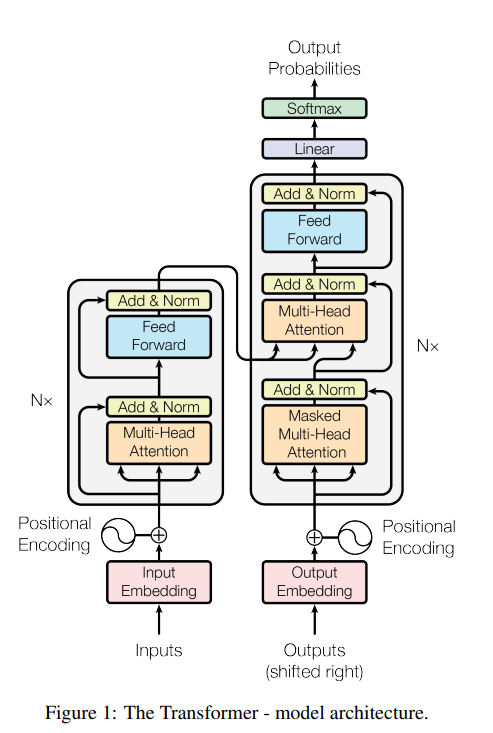

In [ ]:
# We can look inside the encoder
translation_model.model.encoder

In [ ]:
# and the decoder
translation_model.model.decoder

As can be seen above, both encoder and decoder blocks contain 6 layers. The most important part of these layers are the Attention blocks that make these models so powerful. For now you don't need to understand the full details of the attention mechanism for it's usage in this tutorial. But on a higher level, in the encoder, the attention enables each token of the input sentence to weigh the information of other relevant tokens in the text, which help build richer representations of a sentence's meaning. The attention in decoder helps weigh the important parts of the encoded text as well as the translated text generated so-far to generate the translation one token at a time.

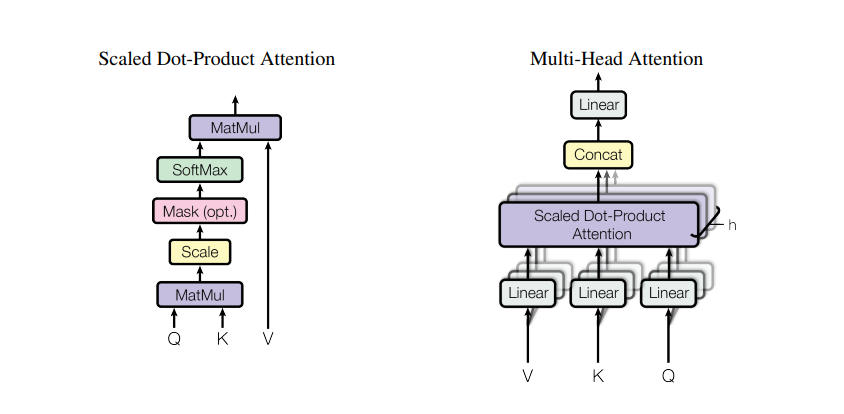

Now that we have some understanding of the model's architecture, we proceed with how to do inference from the same i.e. feeding the input sequence and recovering the generated translation. We start with an input sentence first.

In [ ]:
input_text = "Learning is Fun!"

The inputs to a transformer-based model (or any other sequential neural architectures) are sequence of numbers which denote the indices of each token of the text in the vocabulary of the model. Hence, we first convert the input text into token ids using the tokenizer

In [ ]:
from transformers import AutoTokenizer

# Loading the pre-trained tokenizer for the model we selected
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert the input sentence to token ids
tokenized_inputs = tokenizer(input_text, return_tensors="pt")
print(tokenized_inputs)

As can be seen the tokenizer returns two tensors, first the `'input_ids'` which exactly what we needed i.e. the indices of each token in the sequence. It also returns something called an `'attention_mask'`. For now this can be ignored, we will re-visit this when we do batch-inference.

Now that we have the inputs in the form we wanted, we can feed it to the model to obtain translation. For Seq2Seq models, we can use the `generate` method to obtain the decoded translation. Below we demonstrate how to do so.

In [ ]:
generation = translation_model.generate(input_ids = tokenized_inputs["input_ids"])
print(generation)

Similar to the inputs to model being a sequence of token ids, the outputs are also a sequence of ids corresponding to the output text. We can obtain the decoded text from the output token ids by using the `batch_decode` function of the tokenizer.

In [ ]:
generation_text = tokenizer.batch_decode(generation)
print(generation_text)

We can avoid predicting tokens like `<pad>` by setting `skip_special_tokens=True` while calling batch_decode

In [ ]:
generation_text = tokenizer.batch_decode(generation, skip_special_tokens=True)
print(generation_text)

Now that we have a well-rounded understanding of the inner workings of a translation pipeline, we can implement it on our own. Complete the methods of the class `TranslationPipeline` below, by adding all the functionalities taught above:

In [ ]:
class CustomTranslationPipeline:
    
    def __init__(self, model: str, tokenizer: str):
        """
        Initializes the model and tokenizer for a translation pipeline
        
        Inputs:
            - model (str) : Huggingface model string for the translation model to load
            - tokenizer (str) : Huggingface tokenizer string for the translation model to load.
                                    Often will be same as `model_name`
        """
        
        self.model = None
        self.tokenizer = None
        
        ### BEGIN SOLUTION

        
    def __call__(self, text: str) -> str:
        """
        Takes in an input text and generates the translation
        
        Inputs:
            - text (str) : Input text to be translated
        
        Returs:
            str: Translated text
        
        Steps to follow:
            - Tokenize the `text` to obtain token ids
            - Feed the ids through the model to obtain output ids
            - Convert output ids to text
        """
        
        ### BEGIN SOLUTION
        
        
        return generated_text[0]

In [ ]:
pipeline = CustomTranslationPipeline(model_name, model_name)
pipeline("I like object oriented programming.")

### Prompting Based Translation

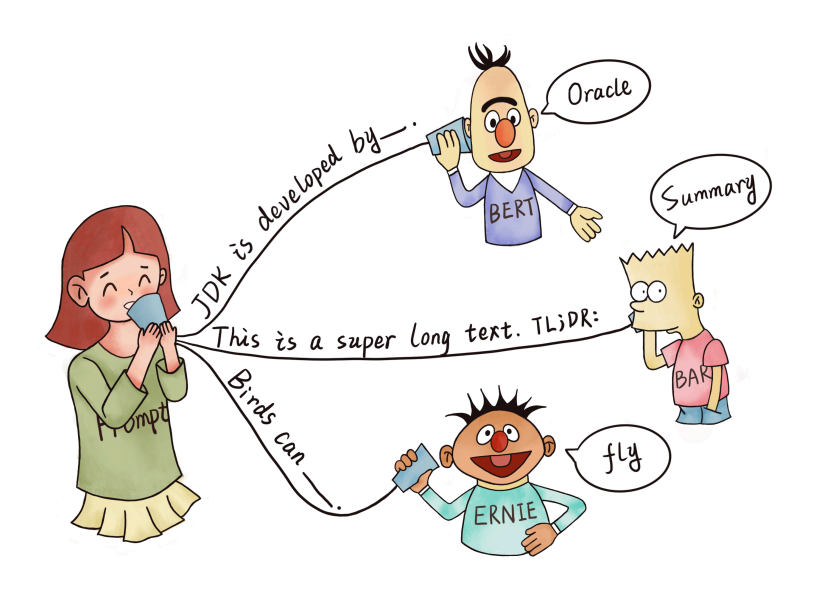

[From Liu et al. 2023](https://dl.acm.org/doi/full/10.1145/3560815)


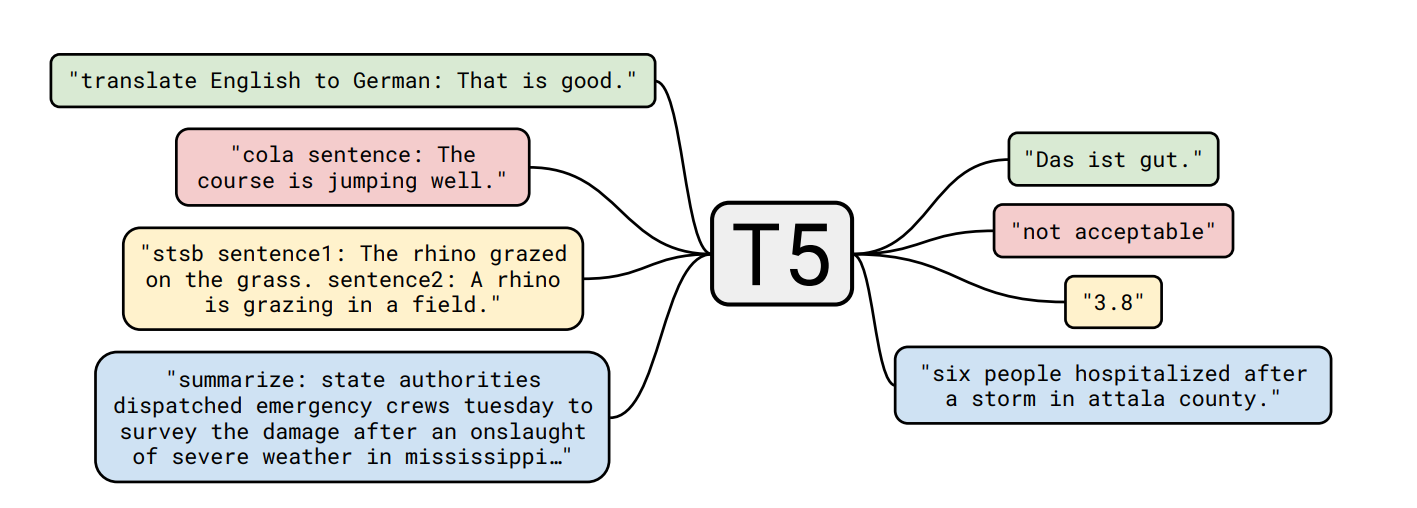

[From Raffel et al. 2019](https://arxiv.org/abs/1910.10683)

Recently, the field of NLP has been undergoing a paradigm shift where the initial approach of fine-tuning pre-trained Language Models on specific tasks is now getting replace with a "Prompting" based approach. The idea behind prompting is that given a Large Language Model (LLM) trained on unlabelled (or labelled) text corpora, can be directly asked to do any task by specifying the instructions about the task in hand as a text description. This generally requires no updates to the parameters of the LLM and has been show competitive with fine-tuning based approaches on many tasks. For translation specifically, one can specify in the beginning the languages from and to translate and the provide the text to be translated:

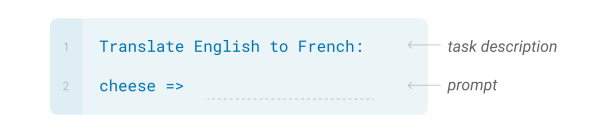

[From Brown et al. 2020](https://arxiv.org/pdf/2005.14165.pdf)

Below we will demonstrate how we can use this approach practically to obtain translations. As before, we start by loading the pre-trained models and tokenizers from the transformers library. Some example models supporting prompt-based translation that are publically available include:

- [T5](https://huggingface.co/docs/transformers/model_doc/t5)
- [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5)
- [BLOOM](https://huggingface.co/docs/transformers/model_doc/bloom)*
- [GPT-2](https://huggingface.co/gpt2)*
- [XGLM](https://huggingface.co/docs/transformers/model_doc/xglm)*

*Models are decoder-only model i.e. models with just the decoder and no-encoder. These are generally used for training LLMs like GPT-x. Their usage in the transformers library will be slightly different, which we will conver in the later tutorials.

In [ ]:
# We first initialize the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

We first create a prompt that is to be fed to the model for response

In [ ]:
input_text = "Learning is fun!"
prompt = "translate English to French: {}".format(input_text)
print(prompt)


In [ ]:
tokenized_prompt = tokenizer(prompt, return_tensors="pt")
model_output = model.generate(input_ids = tokenized_prompt["input_ids"])
generation_text = tokenizer.batch_decode(model_output)
print(generation_text)

We can similarly modify the prompt to translate to German

In [ ]:
input_text = "Learning is fun!"
prompt = "translate English to German: {}".format(input_text)
tokenized_prompt = tokenizer(prompt, return_tensors="pt")
model_output = model.generate(input_ids = tokenized_prompt["input_ids"])
generation_text = tokenizer.batch_decode(model_output)
print(generation_text)

In [ ]:
input_text = "Lernen Sie Spaß!"
prompt = "translate German to English: {}".format(input_text)
tokenized_prompt = tokenizer(prompt, return_tensors="pt")
model_output = model.generate(input_ids = tokenized_prompt["input_ids"])
generation_text = tokenizer.batch_decode(model_output)
print(generation_text)

Let's Try Hindi

In [ ]:
input_text = "Learning is fun!"
prompt = "translate English to Hindi: {}".format(input_text)
tokenized_prompt = tokenizer(prompt, return_tensors="pt")
model_output = model.generate(input_ids = tokenized_prompt["input_ids"])
generation_text = tokenizer.batch_decode(model_output)
print(generation_text)

T5 is limited when it comes to it's capabilities for translation using prompts. Prompting based methods are generally effective for very large scale langaue models with billions of parameters. Unfortunately, it won't be possible to work with those models with the limited compute of this notebook. But we encourage you all to visit: https://chat.openai.com/chat , to try out ChatGPT to perform translation using prompting.

## Task 4: Evaluation

The final topic that we will discuss today is evaluating the translation models for the quality of translations produced by them. The idea behind evaluation is to have a numeric score representing how well the model is doing on the task of translation. As for other machine learning problems, to evaluate we use a labelled test dataset containing the original text and the reference translation created by human annotators. The translation produced by the MT system is compared with the reference translation to obtain the score representing the quality of translation. There are a number of different metrics that are used to measure this, some of which we will be discussing in detail in the next lecture. For this tutorial we will be focusing on BLEU score which on a very high level measures the n-gram overlap between the generated and reference translation. A BLEU score of 1 means perfect translation and 0 is the minimum score meaning no n-gram matches between the reference and generation. You can refer to this [article](https://en.wikipedia.org/wiki/BLEU) for more details.

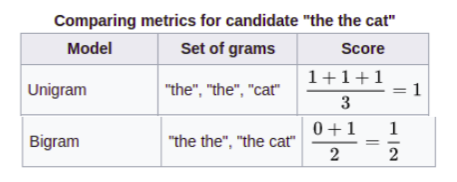

We will first load the test dataset to use for evaluating the quality of translations. We will be using the [FLORES-200](https://github.com/facebookresearch/flores/tree/main/flores200) benchmark, which contains parallel data in 200 languages. The zip file accompanying the tutorial that contains ther data can be uploaded by clicking on Add Data button towards the top-right side of your notebook.

In [ ]:
def read_file(filename):
    with open(filename) as f:
        lines = f.read().split("\n")
    return lines

#Loading English Data
en_data = read_file("/kaggle/input/flores/flores200_dataset/dev/eng_Latn.dev")

# Loading French Data
fr_data = read_file("/kaggle/input/flores/flores200_dataset/dev/fra_Latn.dev")

# Display a sample of data
for i in range(5):
    print(f"English: {en_data[i]}")
    print(f"French: {fr_data[i]}")
    print("="*25)


Now that we have loaded the test dataset, we can use it to evaluate the quality of translation of an MT model. We can use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library for directly evaluating BLEU scores for the generated translations.

In [ ]:
# We can load the bleu evaluation instance from the evaluate library
import evaluate
sacrebleu = evaluate.load("sacrebleu")

As an example we will show comparing quality of English -> French translation for the Marian model we saw before

In [ ]:
# Initializing our Custom Translation Pipeline
translation_pipeline = CustomTranslationPipeline(
    model="Helsinki-NLP/opus-mt-en-fr",
    tokenizer="Helsinki-NLP/opus-mt-en-fr"
)

# Evaluating on the first example
input_text = en_data[0]
reference_text = fr_data[0]
translated_text = translation_pipeline(input_text)
bleu_score = sacrebleu.compute(predictions = [translated_text], references=  [reference_text])["score"]

print(f"Input: {input_text}")
print(f"Reference: {reference_text}")
print(f"Generation: {translated_text}")
print(f"BLEU Score: {bleu_score}")

In [ ]:
def evaluate_translation_pipeline(
    translation_pipeline,
    input_data,
    reference_data,
):
    """
    Evaluates a translation pipeline using BLEU score
    
    Inputs:
        - translation_pipeline (CustomTranslationPipeline)
        - input_data (List[str]) : A list containing sentences in source language to be translated
        - reference_data (List[str]) : Reference translations of the source langauge data
        
    Returns:
        - float: BLEU score for the translation pipeline on the test data
    """
    
    bleu_score = None
    
    ### BEGIN SOLUTION
    
    return bleu_score

In [ ]:
evaluate_translation_pipeline(
    translation_pipeline,
    en_data,
    fr_data
)

## Homework: Benchmarking MT Models

For this week's home-assignment, we want you to take all that you understood from the tutorial above and use the learnings to evaluate different pre-existing MT models on a language of your choice. Just ensure that the language you select has data in the FLORES-200 benchmark and you can find at least 3 different available models on huggingface for the same. You can find the available translation models [here](https://huggingface.co/models?pipeline_tag=translation&sort=downloads). Also, we expect you to evaluate both models for English -> Language as well as Language -> English. Additionally, if you choose to benchmark for a high-resource language like German, French or Spanish, we would also expect you to evaluate a Prompt-based translation model like FLAN-T5. At the end of the benchmarking excercise you should produce a results table of the following format:

| Model                                      | Translation Direction | Number of Encoder Layers      | Number of Decoder Layers      | BLEU         |
|--------------------------------------------|-----------------------|-------------------------------|-------------------------------|--------------|
| [Some Model_1]                             | En->Lang              | [Value given in model.config] | [Value given in model.config] | [BLEU score] |
| [Similar to Model_1 but reverse direction] | Lang->En              | [Value given in model.config] | [Value given in model.config] | [BLEU score] |
| .                                          | .                     | .                             | .                             | .            |

Based on the results obtained, we want you to answer the following questions:
1. What is the impact of number of encoder and decoder layers on the BLEU scores?
2. Compare the two translation directions En->Lang and Lang->En, are the scores obtained for an equivalent model same for both directions or is one often better than the other?
3. [Optional] You can also experiment with other parameters that might help explain the final performance like number of embeddings, hidden size, number of heads etc. All such information can be found in `model.config`.